<a href="https://colab.research.google.com/github/jjzsilva9/vico/blob/main/VICO_Practical_Week_6_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VICO Practical Week 6: Non-Photorealistic Rendering and Ray Tracing.

During this week's face-to-face lecture, we discussed both non-photorealistic rendering and began talking about the principles behind ray tracing.
We will now practice these concepts.


##Part 1: Non-photorealistic rendering (tasks 1-4)
First, you are going to try non-photorealistic rendering: you will create an approximate rendering of an arbitrarily shaped object without using a renderer (at least, not for the object itself!).

To do this, we are going to use MatCaps. A MatCap is simply the (rendered or artist-painted) appearance of a sphere under some illumination. Therefore, lighting and material are "baked into" the image.

The appearance of the sphere can be transferred to arbitrary-shaped objects (with a known normal map), using a lookup based on screen-space normals. This is possible since a sphere displays all surface normal directions over the visible hemisphere.

The lookup-based transfer is summarised in the following images:

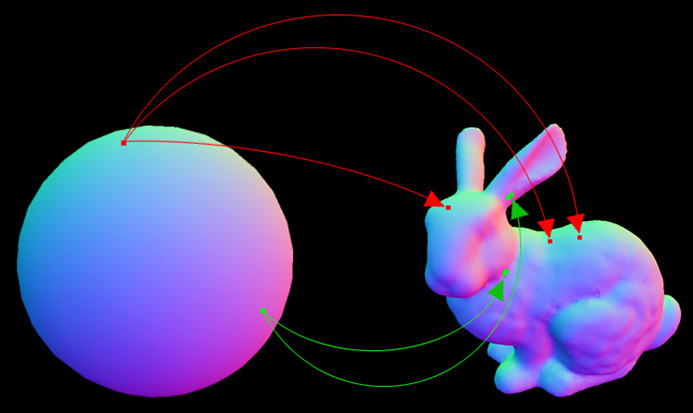

In the above, normal-based lookup.

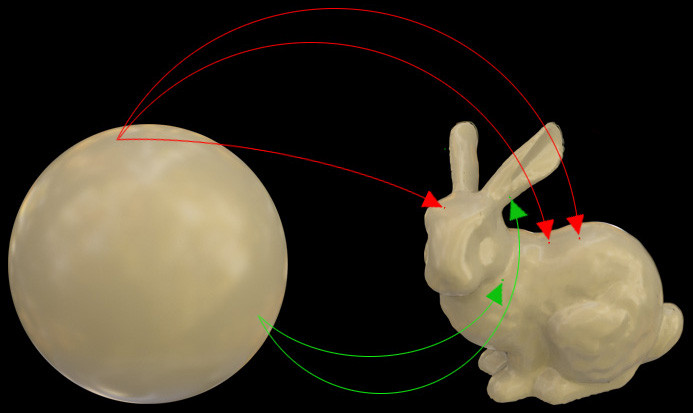

Appearance transfer.

Images taken from D. Guarnera, "Image based surface reflectance remapping for consistent and tool independent material appearence", PhD Thesis (2018).





---


### Task 1: Create the MatCap (point light illumination)

The first thing we need to do is to create the MatCap. For this task, we will use Mitsuba v0.6.

Starting from the XML file provided below, render the reference sphere under point light illumination.
The light should have an intensity of 2000 units of power per steradian; the coordinates of the light need to be ```xyz = (-10, 10, 20) ```.

As for the material, use a rough gold finish, rendered with the GGX distribution, with a surface roughness of $\alpha=0.15$.

You can either tone-map the rendered image using the Mitsuba GUI utilities or using the OpenCV tone-mapper (refer to Week 5 practical).

You can find the XML scene file for this task [here](https://www.dropbox.com/s/iuzj3ybvxilinp9/Vico_WeeK1Summer_sphere.xml).

The MatCap should look similar to the image provided:

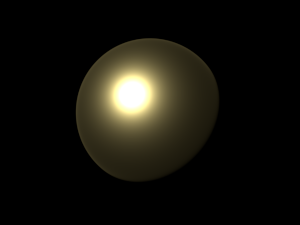


Here's the link to the Mitsuba [documentation](https://www.mitsuba-renderer.org/releases/current/documentation_lowres.pdf).

Mitsuba employs a right-handed coordinate system for the world coordinates (distinct from the local reference frame used for BRDF computations), in which the z-axis points out of the screen:


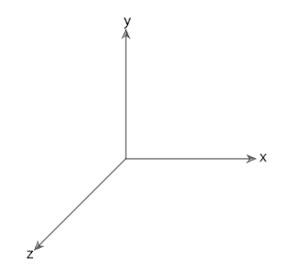

Since we are focusing on non-photorealistic rendering, feel free to hand-paint the sphere if you are adept with drawing software and have the necessary tools!







---


###Task 2: Create a mask for the MatCap and compute the normal map (*optional*).

Note: *Complete this task if you wish to practice creating object binary masks and normal maps from rendered images. Otherwise, use the following lines of code at the beginning of Task #3 to get the maps (mask and normals) required for Task 3:*

```
!wget https://www.dropbox.com/s/oei1halzqjjc3lc/sphere_mask.png
# get the normal map from the following zip file
!wget https://www.dropbox.com/s/p96vml2evun1bhi/assets.zip
!unzip assets.zip
```


To create a mask, use the same scene as before but assign a diffuse reflectance of zero to the sphere; replace the point light with a uniform white environment map. After rendering the image, you can simply threshold and invert it to obtain the mask.

The uniform white environment map is available [at this link](https://www.dropbox.com/s/l3uqisq1adaeigt/envmap_white.exr).

Regarding the normal map, you have options: either calculate it analytically or wait to use photometric stereo (we will revisit this when photometric stereo has been properly introduced, in a few weeks).

If you choose to calculate the sphere's normals analytically, keep in mind the non-photorealistic nature of the MatCap technique. You might opt to disregard the perspective transformation caused by the camera and assume the sphere is rendered in orthographic projection. However, this approach may slightly warp the normal directions.



---


###Task 3: Time to "render"!

We will use the normal map of the cat figurine to drive the appearance transfer. In the coming weeks, you will learn to compute the normal map yourself using photometric stereo. For the time being, however, it will be provided.

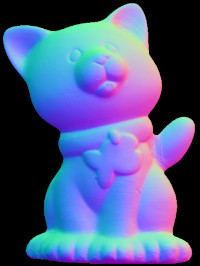


For each pixel $(x_c,y_c)$ within the cat's figurine mask, take the normal direction $n_{c_{(x_c,y_c)}}$ of the pixel into account. Look for the pixel
$(x_s,y_s)$ in the sphere normal map whose normal  $n_{s_{(x_s,y_s)}}$  is most closely aligned with $n_{c_{(x_c,y_c)}}$, as determined by the highest cosine similarity.

When you have found a close match, assign to the pixel $(x_c,y_c)$  in the "rendered" cat image the RGB colour of the corresponding pixel $(x_s,y_s)$  from the MatCap.

The cosine similarity between two vectors $V_1$ and $V_2$ is given by $\cos\theta=\frac{V_1 \cdot V_2}{\lVert V_1  \rVert \lVert  V_2  \rVert}$.

Be aware that a naive implementation's complexity is $\mathcal{O}(n^4)$ (assuming $n$ is the diameter of the sphere in pixels and the object to be rendered is of a similar size). To improve efficiency, consider downsampling both the sphere's and the object's normal maps by a factor of 2 in each dimension. You might implement a number of optimizations, for example:

*   Cease searching when a matching normal with a cosine similarity of at least 0.995 is found (corresponding to an angular error of about $2.5^{\circ}$);
*   Take into account that on a smooth surface, the normal direction typically does not vary drastically from one pixel to its neighbor, barring the presence of an edge or a very thin geometric structure.
*   Quantise the normals and organize them into one or more lookup tables (or similar structures) for expedited retrieval.
*   ...




In [1]:
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt

!wget https://www.dropbox.com/s/ojdqmbzdtxwbs7q/nmaps_and_masks.zip
!unzip nmaps_and_masks.zip

--2024-11-10 11:13:39--  https://www.dropbox.com/s/ojdqmbzdtxwbs7q/nmaps_and_masks.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/7qkaaou5tz74s6gnpled7/nmaps_and_masks.zip?rlkey=7uyl0kuw3fche0hq210uoybal [following]
--2024-11-10 11:13:39--  https://www.dropbox.com/scl/fi/7qkaaou5tz74s6gnpled7/nmaps_and_masks.zip?rlkey=7uyl0kuw3fche0hq210uoybal
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfd40d43d3a75a46382f135b906.dl.dropboxusercontent.com/cd/0/inline/CeHUgcD6pfR4Kr1y0t_OtGbdF7KB0X0aCmF0WFhFbJlN32o--nnaYP2O9ttaTdzHJpg5zDQU3YokE_mKplIZdtO3TPhHWtGK9xiPl80eOXad0mUiJVj7pvUVjzYIXhNTncjPOaBYmcBQXzuttVP_T9qg/file# [following]
--2024-11-10 11:13:40--  https://ucfd40d43d3a75a46382f135b906.dl.dropboxusercont

(512, 683, 3)
{(0.0, 0.0, 0.0): array([0, 0, 0], dtype=uint8), (1.0, 0.0, 0.0): array([191, 176, 116], dtype=uint8), (1.0, 1.0, 0.0): array([205, 189, 125], dtype=uint8), (2.0, 1.0, 1.0): array([255, 255, 194], dtype=uint8), (2.0, 2.0, 1.0): array([255, 255, 210], dtype=uint8), (3.0, 2.0, 1.0): array([255, 255, 237], dtype=uint8), (3.0, 3.0, 1.0): array([255, 255, 255], dtype=uint8), (4.0, 3.0, 1.0): array([255, 255, 255], dtype=uint8), (5.0, 4.0, 2.0): array([255, 255, 255], dtype=uint8), (4.0, 4.0, 1.0): array([255, 255, 255], dtype=uint8), (6.0, 5.0, 2.0): array([255, 255, 255], dtype=uint8), (7.0, 6.0, 2.0): array([255, 255, 255], dtype=uint8), (8.0, 7.0, 3.0): array([255, 255, 255], dtype=uint8), (9.0, 7.0, 3.0): array([255, 255, 255], dtype=uint8), (9.0, 8.0, 3.0): array([255, 255, 255], dtype=uint8), (10.0, 8.0, 3.0): array([255, 255, 255], dtype=uint8), (11.0, 9.0, 4.0): array([255, 255, 255], dtype=uint8), (12.0, 10.0, 4.0): array([255, 255, 255], dtype=uint8), (7.0, 5.0, 2.0)

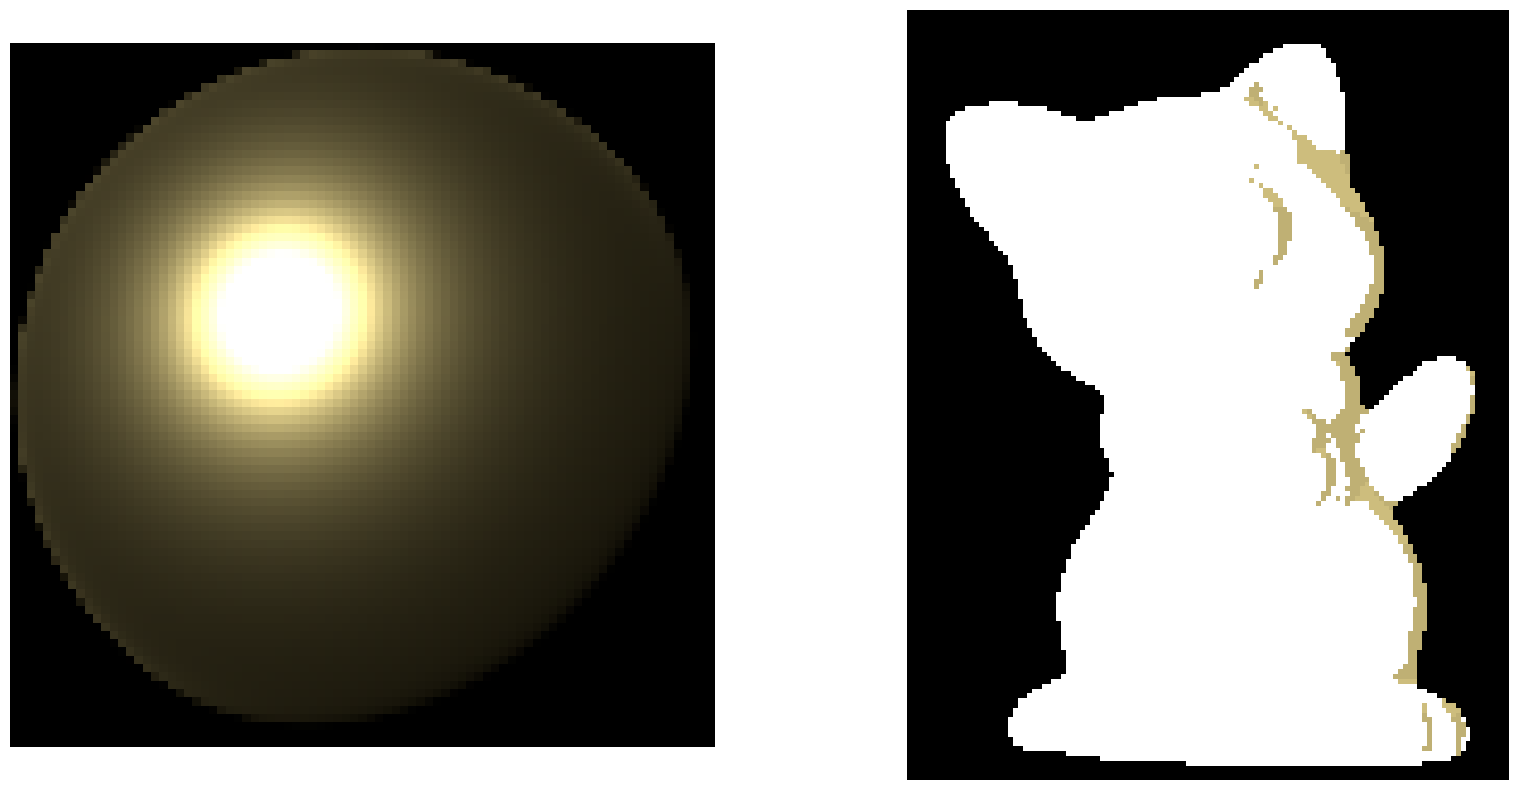

In [25]:
# cat normal map and mask are already contained in the zip folder
with open('cat_normal_map.npy', 'rb') as f:
    cat_normal_map = np.load(f)

cat_mask = cv2.imread('cat_mask.png', cv2.IMREAD_GRAYSCALE)

# You need to generate the matcap, its mask and the sphere normal map first! See tasks 1 and 2
with open('sphere_normal_map.npy', 'rb') as f:
    sphere_normal_map = np.load(f)

print(sphere_normal_map.shape)

matcap = cv2.cvtColor(cv2.imread('matcap.png'),cv2.COLOR_BGR2RGB)
sphere_mask = cv2.imread('sphere_mask.png', cv2.IMREAD_GRAYSCALE)

# The image of the matcap shows that there is a large number of black pixels around the rendered sphere.
# They are just going to slow things down, so let's skip most of the background around the sphere.
# The values reported in the following make sense only if you have followed all the instruction in tasks 1 and 2.
# We can also downsample mask, normal map and matcap to speed things up a bit.
downsampling_factor_matcap = 4
sphere_mask = sphere_mask[86:425:downsampling_factor_matcap, 172:510:downsampling_factor_matcap];
matcap = matcap[86:425:downsampling_factor_matcap, 172:510:downsampling_factor_matcap];
sphere_normal_map = sphere_normal_map[86:425:downsampling_factor_matcap, 172:510:downsampling_factor_matcap];

# We can downsample the cat normal map and mask too. Clearly, the rendered image will also be downsampled by the same factor.
downsampling_factor_cat = 4
cat_normal_map = cat_normal_map[0:cat_normal_map.shape[0]:downsampling_factor_cat, 0:cat_normal_map.shape[1]:downsampling_factor_cat]
cat_mask = cat_mask[0:cat_mask.shape[0]:downsampling_factor_cat, 0:cat_mask.shape[1]:downsampling_factor_cat]

sphere_normal_dic = {}

for row in range(0, sphere_normal_map.shape[0]):
  for col in range(0, sphere_normal_map.shape[0]):
    sphere_normal_dic[tuple(np.round(sphere_normal_map[row][col]))] = matcap[row][col]
# the "rendered" image will be stored here
rendered_cat = np.zeros((cat_normal_map.shape[0],cat_normal_map.shape[1],3))
print(sphere_normal_dic)
for row in range(0,cat_normal_map.shape[0]):
  for col in range(0,cat_normal_map.shape[1]):
    if cat_mask[row,col]:

      # intitialise the variables to keep track of the best matching normal direction
      best_match = -1
      # we need to keep track of the pixel location where the best matching normal has been found
      best_match_row = -1
      best_match_col = -1
      # your code goes here
      #print(cat_normal_map[row][col])
      if tuple(np.round(cat_normal_map[row][col])) in sphere_normal_dic:
        rendered_cat[row,col,:] = sphere_normal_dic[tuple(np.round(cat_normal_map[row][col]))]
      else:
        rendered_cat[row, col,:] = [255,255,255]



fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(matcap)
# the following line assumes you saved the matcap as a 8bit tonemapped rgb image
axes[1].imshow(rendered_cat/255)
axes[0].axis('off')
axes[1].axis('off')
plt.show()


---

### Task 4: editing the light direction

One of the limitations of MatCaps is that the lighting is "baked in" the image of the sphere. Generally, lighting cannot be simply edited. However, with the lighting direction used in our MatCap, simulating rotations around the $z$ axis is straightforward!

***Without*** using Mitsuba to generate a new MatCap, rotate the lighting in the existing one by increments of 30 degrees. Create an animation of the cat figurine to display the changes in lighting.

In [ ]:
# the purpose of the following block of code is mostly to setup the figure to preview the rotated matcaps
figure = plt.figure(figsize=(20, 20))
matcaps = []
matcaps.append(matcap)
figure.add_subplot(1, 12, 1)
plt.imshow(matcap)
angle = 30

for i in range(1, 12):

  # your code goes here

  figure.add_subplot(1, 12, i+1)
  plt.imshow(matcap)
  plt.axis('off')

plt.show()

# for each matcap in matcaps, the appearance needs to be transferred to the cat, in order to create the animation.
# For doing this, simply reuse the code from task 3 to create the frames for the animation

##Part 2: ray tracing

### Task 5: Rays - intersections and reflections

Consider a scene that contains a mirror and a sphere (see the figure below, not in scale).

We know the coordinates of 4 points that lie on the mirror (assumed to be infinite):
    
*   $p_1(5.169, 2.170, 1.729)$,
*   $p_2(7.130, 0.363, 5.759)$,
*   $p_3(0.317, 8.586, 8.650)$,
*   $p_4(3.757, 3.379, -1.954)$.

The sphere has radius $r_S=1$, and it is centered at  $p_c(2.321, 9.845, 4.121)$.

Given a ray with origin $p_0(5.715, 5.010, 5.229)$ and direction $\mathbf{r_d}=\left[-0.992, 0.123, -0.013 \right]$, determine if the ray intersects the mirror and if (and where) the reflected ray intersects the sphere.

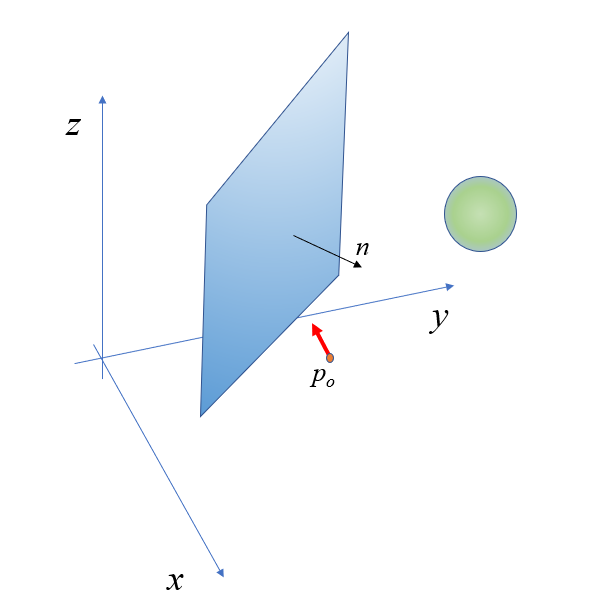

In [ ]:
from numpy import linalg as LA
# we need 3 points to compute the equation of a plane (the mirror, in this case). Let's say we select p1, p2 and p3 for this task.

p1 = [5.169, 2.170, 1.729]
p2 = [7.130, 0.363, 5.759]
p3 = [0.317, 8.586, 8.650]

# For the sake of using the same notation as in the slides, we can create the following variables.
# Assign the coordinates of the points to the variables x1, y1, z1, etc.
# These variables correspond to the coordinates of the points.
# (Complete the assignments with the correct values from p1, p2, and p3)

x1 =
y1 =
z1 =
x2 =
y2 =
z2 =
x3 =
y3 =
z3 =

# Compute vectors U and V that are on the plane using points p1, p2, and p3.
# Replace the 'None' with the correct computation.
u1 =
u2 =
u3 =

v1 =
v2 =
v3 =

# normal to the plane
n = # your code goes here

# Equation of the plane: ax + by +cz + d ; with n = [a, b, c]
# Compute the 'd' coefficient of the plane's equation using point p1 and the normal.

d = # your code goes here

# find out if and where the ray intersects the mirror, solving for t:
# origin of the ray:
po = [5.715, 5.010, 5.229]
rd = [-0.992, 0.123, -0.013]

# You will need to solve for t using the ray equation and the plane's equation
# Your code to calculate 't' (the variable tp in the following) goes here
tp =


#intersection ray-plane:
pi = np.empty([3])
# your code goes here

# if there is an intersection, then the ray will be reflected specularly. Compute the reflected ray!

# your code goes here

# test if the reflected ray intersects the sphere

# your code goes here
